# Make weighted manual subset

To reduce the amount of manual coding labor, we didn't create the weighted subset through a completely separate sampling operation. Instead I (Underwood) calculated how a weighted sample would be distributed across the range of reprinting-frequencies, and randomly sampled a *supplement* to make up the difference between a sample representing distinct titles and a sample representing volumes.

Now we have to load that supplement and merge it with the title sample, after randomly removing volumes from the title sample. All the volumes we remove will be those only appearing once in Hathi; the volumes we add will all have more than one appearance.

In [74]:
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from difflib import SequenceMatcher
%matplotlib inline

### Load the data, standardize data dictionary

In [47]:
j = pd.read_csv('weighteddata/jessicamanycopies.csv', index_col = 'docid')
p = pd.read_csv('weighteddata/patrickmanycopies.csv', index_col = 'docid')
t = pd.read_csv('weighteddata/tedmanycopies.csv', index_col = 'docid')

In [48]:
j['gender'] = j['gender'].fillna(value = 'u')
p['gender'] = p['gender'].fillna(value = 'u')
t['gender'] = t['gender'].fillna(value = 'u')

In [49]:
def dominant_category(astring):
    ''' Accepts a category string that may contain multiple
    values, and reduces it to a single category.
    '''
    astring = astring.replace(' ', '')
    cats = astring.split('|')
    if 'nonfic' in cats:
        return 'nonfic'
    if 'poetry' in cats:
        return 'poetry'
    if 'drama' in cats:
        return 'drama'
    if 'reprint' in cats:
        return 'reprint'
    if 'juvenile' in cats:
        return 'juvenile'
    if 'shortstories' in cats:
        return 'shortstories'
    if 'novel' in cats:
        return 'novel'
    else:
        return 'error'

j = j.assign(category = j.category.map(dominant_category))
p = p.assign(category = p.category.map(dominant_category))
t = t.assign(category = t.category.map(dominant_category))

### How much do human readers agree?

The three readers in this portion of the project worked on overlapping sets of books, allowing us to roughly estimate average levels of agreement.

Note that "agree" may be the wrong verb here, if it suggests as the other alternative a settled and irreconcilable *dis*agreement. Many cases of "disagreement" below are just data entry errors. In other cases, we probably could have come to consensus given a bit more time to discuss the meanings of categories. But in this project, we weren't working to stabilize a local consensus for the purposes of a particular experiment. We were rather producing a dataset that we expect to be borrowed by other people, who may or may not share our consensus. So it seemed appropriate to report a first (low) estimate of agreement; that will be more likely to reflect the intersubjective conditions operative for users of this project who know nothing but the names of the categories we used.

In [50]:
def measure_agreement(category):
    agreement = Counter()
    differences = []
    
    frames = [j, p, t]
    for index1 in range(0, 3):
        for index2 in range(index1 + 1, 3):
            print(index1, ' - ', index2)
            frame1 = frames[index1]
            frame2 = frames[index2]
            overlap = set(frame1.index).intersection(set(frame2.index))
            for docid in overlap:
                value1 = frame1.loc[docid, category]
                value2 = frame2.loc[docid, category]
                if value1 == value2:
                    agreement[True] += 1
                elif pd.isnull(value1) and pd.isnull(value2):
                    agreement[True] += 1
                else:
                    agreement[False] += 1
                    differences.append((value1, value2, docid))

    return agreement, differences

In [51]:
genagreement, genderdiffs = measure_agreement('gender')

0  -  1
0  -  2
1  -  2


In [52]:
genagreement[True] / (genagreement[False] + genagreement[True])

0.9506172839506173

In [53]:
genderdiffs

[('m', 'f', 'uc2.ark+=13960=t3xs5q555'),
 ('u', 'm', 'uc1.b3295312'),
 ('m', 'u', 'uc2.ark+=13960=t08w3hh7p'),
 ('m', 'f', 'mdp.39015039779825'),
 ('m', 'u', 'mdp.39015061860105'),
 ('f', 'm', 'mdp.39015016445929'),
 ('u', 'm', 'mdp.39015000017445'),
 ('m', 'f', 'nyp.33433074865746')]

In [54]:
catagreement, catdiffs = measure_agreement('category')

0  -  1
0  -  2
1  -  2


In [55]:
catagreement[True] / (catagreement[False] + catagreement[True])

0.8827160493827161

In [56]:
catdiffs

[('novel', 'shortstories', 'nyp.33433074866611'),
 ('nonfic', 'novel', 'nyp.33433075764427'),
 ('novel', 'shortstories', 'uc1.b3295312'),
 ('reprint', 'nonfic', 'njp.32101054938426'),
 ('reprint', 'novel', 'mdp.39076006602267'),
 ('shortstories', 'nonfic', 'uc2.ark+=13960=t08w3hh7p'),
 ('shortstories', 'reprint', 'uc2.ark+=13960=t81j9qk9w'),
 ('novel', 'shortstories', 'mdp.39015008170220'),
 ('novel', 'nonfic', 'uiuo.ark+=13960=t3kw5sm3s'),
 ('nonfic', 'novel', 'nyp.33433075764427'),
 ('novel', 'shortstories', 'mdp.39015066681480'),
 ('shortstories', 'novel', 'hvd.32044090343690'),
 ('nonfic', 'shortstories', 'mdp.39015073934724'),
 ('juvenile', 'novel', 'uiuo.ark+=13960=t1pg2cj2j'),
 ('novel', 'nonfic', 'uc2.ark+=13960=t7sn04f3b'),
 ('shortstories', 'novel', 'hvd.32044090343690'),
 ('reprint', 'novel', 'uc2.ark+=13960=t6736q45t'),
 ('shortstories', 'novel', 'uc1.$b795540'),
 ('shortstories', 'novel', 'wu.89087923348')]

In [57]:
nationagreement, nationdiffs = measure_agreement('nationality')

0  -  1
0  -  2
1  -  2


In [58]:
nationagreement[True] / (nationagreement[False] + nationagreement[True])

0.8641975308641975

In [59]:
nationdiffs

[(nan, 'uk', 'uiuo.ark+=13960=t2t44bz9q'),
 (nan, 'uk', 'nyp.33433075764427'),
 ('uk', 'us', 'mdp.39015008540703'),
 (nan, 'us', 'uc1.b3295312'),
 ('us', 'uk', 'hvd.32044090343690'),
 (nan, 'ir', 'uc1.$b686387'),
 ('ukr', 'ru', 'nyp.33433073355830'),
 ('in', nan, 'mdp.39015061860105'),
 ('ir', 'uk', 'mdp.39015059404106'),
 ('uk', nan, 'uiuo.ark+=13960=t8sb4r697'),
 (nan, 'uk', 'nyp.33433075764427'),
 (nan, 'ca', 'uc1.$b323008'),
 ('ir', 'uk', 'uiuo.ark+=13960=t07w6q90x'),
 ('us', 'uk', 'hvd.32044090343690'),
 ('pr', nan, 'mdp.39015073934724'),
 ('uk', nan, 'uiuo.ark+=13960=t50g48273'),
 ('us', 'uk', 'mdp.39015063917739'),
 (nan, 'us', 'mdp.39015000017445'),
 (nan, 'ca', 'uc1.$b323008'),
 ('uk', 'us', 'nyp.33433074812243'),
 ('uk', nan, 'uiuo.ark+=13960=t50g48273'),
 ('ru', 'uk', 'uc1.$b795540')]

#### what fraction of the errors are caused by blanks?

In [60]:
ctr = 0
for d1, d2, doc in nationdiffs:
    if pd.isnull(d1) or pd.isnull(d2):
        ctr += 1
ctr

13

In [61]:
13 / len(nationdiffs)

0.5909090909090909

## Combining the dataframes

This is a two-stage process, because we have to first reconcile the disagreements detailed above.

#### make list of contested volumes

In [66]:
cat = 0
reasons = dict()
allcontested = set()

for diffs in [genderdiffs, catdiffs, nationdiffs]:
    cat += 1
    for a, b, docid in diffs:
        if docid not in reasons:
            reasons[docid] = ""
        if cat == 1:
            reasons[docid] += "gender|"
        elif cat == 2:
            reasons[docid] += "category|"
        else:
            reasons[docid] += "nation|"
            
        allcontested.add(docid)

subset = list(allcontested)

tsub = t.loc[list(set(subset).intersection(set(t.index))), : ]
psub = p.loc[list(set(subset).intersection(set(p.index))), : ]
jsub = j.loc[list(set(subset).intersection(set(j.index))), : ]
tsub = tsub.assign(reader = 't')
psub = psub.assign(reader = 'p')
jsub = jsub.assign(reader = 'j')
subsets = pd.concat([tsub, psub, jsub])
subsets.shape


(72, 18)

In [67]:
# drop duplicate rows

subsets = subsets[~subsets.index.duplicated(keep='first')]
subsets.shape

(34, 18)

In [68]:
subsets['debate'] = subsets.index.to_series().map(reasons)

#### resolve disagreements

In [69]:
# subsets.to_csv('weighteddata/contested_volumes.csv', index_label = 'docid')

# Note that I'm commenting that out, because I don't want it to re-run 
# every time this notebook is run. But on the first pass, this is where I
# wrote to file, and manually edited, a list of contested volumes.

#### make list of uncontested volumes, and combine with contested

In [70]:
allvols = pd.concat([j, p, t])
allvols.drop_duplicates(inplace = True, keep = False)
allvols.shape

(533, 17)

In [71]:
contested = pd.read_csv('weighteddata/contested_volumes.csv', index_col = 'docid')
contested.drop(labels = ['debate', 'reader'], axis = 1, inplace = True)
contested.shape

(34, 17)

In [72]:
allvols = pd.concat([allvols, contested])
allvols.shape

(567, 17)

#### reconsider ```reprint``` category

In [88]:
reprints = allvols.loc[allvols.category == 'reprint', : ]
reprints.shape

(15, 17)

In [89]:
# commenting out because I don't actually want this step to re-run

# reprints.to_csv('weighteddata/reprints.csv', index_label = 'docid')

In [90]:
reprints = pd.read_csv('weighteddata/reprints.csv', index_col = 'docid')
noreprints = allvols.loc[allvols.category != 'reprint', : ]
noreprints = noreprints.assign(hathiadvent = 'contemporary')
print("reprints: ", reprints.shape)
print("noreprints: ", noreprints.shape)

reprints:  (15, 18)
noreprints:  (552, 18)


In [91]:
allvols = pd.concat([noreprints, reprints])
allvols.shape

/Users/tunder/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


(567, 18)

## Merging the frequently-reprinted supplement with the title_subset

To do this, we first have to remove an equal number of rarely-reprinted volumes, distributed similarly across the timeline.

In [81]:
title = pd.read_csv('manual_title_subset.tsv', sep = '\t', index_col = 'docid')

In [85]:
toremove = []

for floor in range(1800, 2010, 10):
    originals = title.loc[(title.inferreddate >= floor) & 
                          (title.inferreddate < (floor + 10)) &
                         (title.copiesin25yrs.astype(int) < 2), : ]
    new = allvols.loc[(allvols.inferreddate >= floor) & 
                          (allvols.inferreddate < (floor + 10)), : ]
    k = new.shape[0]
    sample = random.sample(originals.index.tolist(), k)
    toremove.extend(sample)  

In [86]:
len(toremove)

567

In [92]:
title.shape

(2730, 18)

In [93]:
title.drop(labels = toremove, inplace = True)
title.shape

(2163, 18)

In [94]:
all = pd.concat([title, allvols])
all.shape

/Users/tunder/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


(2730, 18)

In [96]:
all.to_csv('weighted_subset.tsv', sep = '\t', index_label = 'docid')

### EDA on gender

In [97]:
def isfiction(astring):
    ''' Note that this doesn't count juvenile fiction.
    '''
    
    if pd.isnull(astring):
        return 'not'

    if 'longfiction' in astring or 'shortfiction' in astring:
            return 'fic'
    else:
        return 'not'

all = all.assign(isfic = all.category.map(isfiction))

In [99]:
def bootstrap_ratio(numtrue, numfalse):
    population = [True] * numtrue + [False] * numfalse
    results = []
    
    for i in range(1000):
        sample = np.random.choice(population, size = len(population), replace = True)
        ratio = sum(sample) / len(sample)
        results.append(ratio)
    
    results.sort()
    return results[49], results[950]

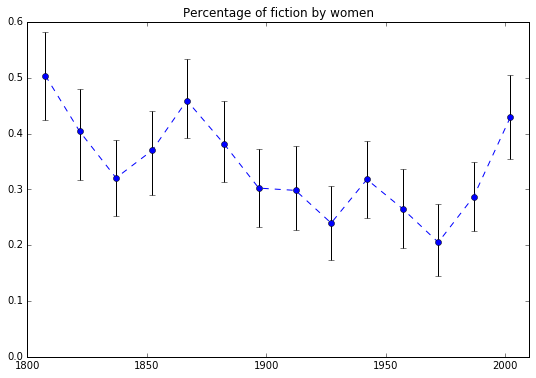

In [100]:
timeaxis = []
percentages = []
minima = []
maxima = []

for decade in range(1800, 2010, 15):
    in_decade = all.loc[(all.firstpub >= decade) & (all.firstpub < (decade + 15)) & ((all.isfic == 'fic')), : ]
    masculine = sum(in_decade.gender == 'm') 
    feminine = sum(in_decade.gender == 'f')
    pct = feminine / (masculine + feminine)
    timeaxis.append(np.mean(in_decade.firstpub))
    percentages.append(pct)
    minimum, maximum = bootstrap_ratio(feminine, masculine)
    maxima.append(maximum)
    minima.append(minimum)

plt.figure(figsize = (9, 6))
plt.xlim(1800,2010)
plt.ylim(0.0, 0.6)
plt.title('Percentage of fiction by women')
downward = np.array(percentages) - np.array(minima)
upward = np.array(maxima) - np.array(percentages)
plt.errorbar(timeaxis, percentages, yerr = [downward, upward], fmt='--o', ecolor = 'k', color = 'b')
plt.savefig('figures/weightedsubset/pctwomen.png')
plt.show() 